In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [ ]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteL92EG6/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteL92EG6/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


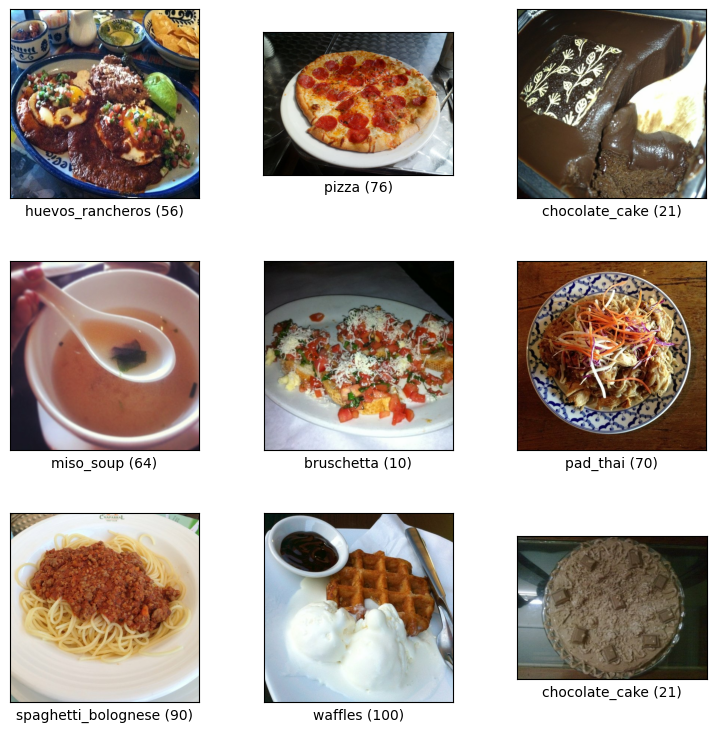

In [ ]:
fig = tfds.show_examples(train_data, ds_info)

In [ ]:
class_names = ds_info.features['label'].names

class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Resizing image to 224x224 and converting uint8 to float16
def preprocess_img(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)
  return image, label

In [ ]:
train_data = train_data.map(preprocess_img, tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, tf.data.AUTOTUNE)
test_data = test_data.batch(32)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
from keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [ ]:
from keras import layers
from keras.layers.experimental import preprocessing

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

for layer in base_model.layers:
    layer.trainable=False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)
x = layers.Dense(101)(x)
outputs = layers.Activation("softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(factor=0.2,monitor='val_accuracy',min_lr=1e-7,patience=0,verbose=1)
early_stop = EarlyStopping(restore_best_weights=True,monitor='val_accuracy',patience=3)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy","sparse_top_k_categorical_accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, None, None, 1280   6575239   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation_1 (Activation)   (None, 101)               0   

In [ ]:
history = model.fit(train_data,
                    epochs=20,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[early_stop,reduce_lr])

Epoch 1/20
2368/2368 [==============================] - 202s 79ms/step - loss: 1.9139 - accuracy: 0.5306 - sparse_top_k_categorical_accuracy: 0.7874 - val_loss: 1.1773 - val_accuracy: 0.6899 - val_sparse_top_k_categorical_accuracy: 0.8994 - lr: 0.0010
Epoch 2/20
2368/2368 [==============================] - 183s 77ms/step - loss: 1.4546 - accuracy: 0.6230 - sparse_top_k_categorical_accuracy: 0.8564 - val_loss: 1.0802 - val_accuracy: 0.7100 - val_sparse_top_k_categorical_accuracy: 0.9137 - lr: 0.0010
Epoch 3/20
2368/2368 [==============================] - 183s 76ms/step - loss: 1.3648 - accuracy: 0.6439 - sparse_top_k_categorical_accuracy: 0.8693 - val_loss: 1.0413 - val_accuracy: 0.7177 - val_sparse_top_k_categorical_accuracy: 0.9155 - lr: 0.0010
Epoch 4/20
2368/2368 [==============================] - 187s 78ms/step - loss: 1.3166 - accuracy: 0.6542 - sparse_top_k_categorical_accuracy: 0.8774 - val_loss: 1.0232 - val_accuracy: 0.7201 - val_sparse_top_k_categorical_accuracy: 0.9171 - lr:

In [ ]:
model.save("/content/drive/My Drive/food_v5.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


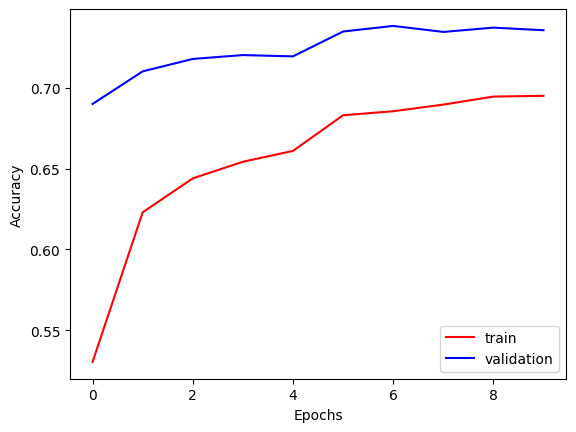

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

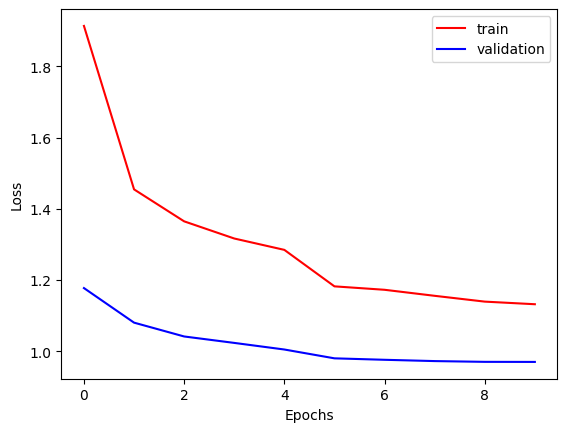

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

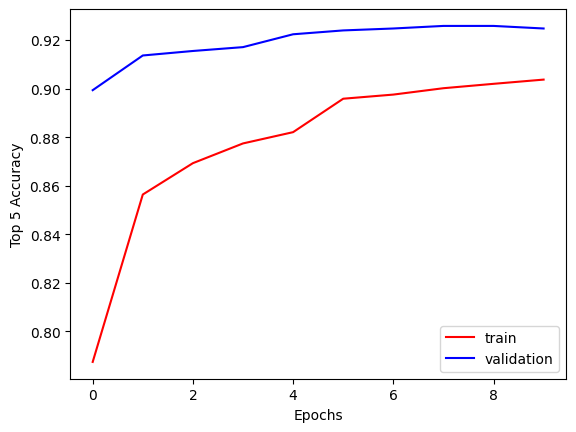

In [ ]:
plt.plot(history.history['sparse_top_k_categorical_accuracy'],color='red',label='train')
plt.plot(history.history['val_sparse_top_k_categorical_accuracy'],color='blue',label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top 5 Accuracy')
plt.show()

In [ ]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 63s 75ms/step


In [ ]:
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3, 94])

In [ ]:
# Getting true labels for the test_data
y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())

y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (100, 100));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues').set_title('Confusion Matrix').set_size(120);

plt.savefig('/content/drive/MyDrive/cnf_matrix_efficientnet.png', bbox_inches='tight')

In [ ]:
from sklearn.metrics import classification_report

report = (classification_report(y_labels, pred_classes, output_dict=True))

In [ ]:
class_f1_scores = {}
class_precision = {}

for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-score/precision to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
    class_precision[class_names[int(k)]] = v["precision"]

In [ ]:
class_f1_scores

{'apple_pie': 0.48337028824833694,
 'baby_back_ribs': 0.7295081967213115,
 'baklava': 0.7436399217221134,
 'beef_carpaccio': 0.7547892720306513,
 'beef_tartare': 0.6157024793388429,
 'beet_salad': 0.5697896749521988,
 'beignets': 0.8287937743190661,
 'bibimbap': 0.8452830188679246,
 'bread_pudding': 0.5173745173745173,
 'breakfast_burrito': 0.6719367588932806,
 'bruschetta': 0.605691056910569,
 'caesar_salad': 0.7412844036697247,
 'cannoli': 0.7861507128309573,
 'caprese_salad': 0.703030303030303,
 'carrot_cake': 0.7246963562753036,
 'ceviche': 0.5197215777262181,
 'cheesecake': 0.55893536121673,
 'cheese_plate': 0.7235772357723577,
 'chicken_curry': 0.688,
 'chicken_quesadilla': 0.7563352826510721,
 'chicken_wings': 0.7906066536203522,
 'chocolate_cake': 0.6299212598425197,
 'chocolate_mousse': 0.5333333333333334,
 'churros': 0.8121212121212122,
 'clam_chowder': 0.8394584139264991,
 'club_sandwich': 0.7871939736346516,
 'crab_cakes': 0.5551470588235293,
 'creme_brulee': 0.814090019569

In [ ]:
class_precision

{'apple_pie': 0.5422885572139303,
 'baby_back_ribs': 0.7478991596638656,
 'baklava': 0.7279693486590039,
 'beef_carpaccio': 0.7242647058823529,
 'beef_tartare': 0.6367521367521367,
 'beet_salad': 0.5457875457875457,
 'beignets': 0.8068181818181818,
 'bibimbap': 0.8,
 'bread_pudding': 0.5,
 'breakfast_burrito': 0.6640625,
 'bruschetta': 0.6157024793388429,
 'caesar_salad': 0.6847457627118644,
 'cannoli': 0.8008298755186722,
 'caprese_salad': 0.710204081632653,
 'carrot_cake': 0.7336065573770492,
 'ceviche': 0.6187845303867403,
 'cheesecake': 0.532608695652174,
 'cheese_plate': 0.7355371900826446,
 'chicken_curry': 0.688,
 'chicken_quesadilla': 0.7376425855513308,
 'chicken_wings': 0.7739463601532567,
 'chocolate_cake': 0.6201550387596899,
 'chocolate_mousse': 0.5565217391304348,
 'churros': 0.8204081632653061,
 'clam_chowder': 0.8127340823970037,
 'club_sandwich': 0.7437722419928826,
 'crab_cakes': 0.5136054421768708,
 'creme_brulee': 0.7969348659003831,
 'croque_madame': 0.725563909774

In [ ]:
sorted_f1 = {k: v for k, v in sorted(class_f1_scores.items(), key=lambda item: item[1], reverse=True)}

sorted_f1

{'edamame': 0.9900199600798404,
 'macarons': 0.9252525252525253,
 'hot_and_sour_soup': 0.9017341040462429,
 'oysters': 0.9007936507936507,
 'miso_soup': 0.8969696969696969,
 'spaghetti_carbonara': 0.8961538461538461,
 'pho': 0.8947368421052632,
 'frozen_yogurt': 0.8871287128712871,
 'sashimi': 0.875968992248062,
 'seaweed_salad': 0.8757637474541752,
 'french_fries': 0.8722986247544204,
 'pizza': 0.8665377176015473,
 'mussels': 0.8661087866108788,
 'guacamole': 0.8641509433962263,
 'onion_rings': 0.8632812500000001,
 'dumplings': 0.857707509881423,
 'cup_cakes': 0.8527131782945736,
 'spaghetti_bolognese': 0.8495934959349594,
 'bibimbap': 0.8452830188679246,
 'escargots': 0.8448979591836734,
 'clam_chowder': 0.8394584139264991,
 'pad_thai': 0.8290909090909091,
 'beignets': 0.8287937743190661,
 'hot_dog': 0.8264150943396227,
 'eggs_benedict': 0.8254620123203286,
 'poutine': 0.8212180746561887,
 'ramen': 0.81947261663286,
 'deviled_eggs': 0.8151093439363816,
 'creme_brulee': 0.814090019569

In [ ]:
sorted_precision = {k: v for k, v in sorted(class_precision.items(), key=lambda item: item[1], reverse=True)}

sorted_precision

{'edamame': 0.9880478087649402,
 'macarons': 0.9346938775510204,
 'mussels': 0.9078947368421053,
 'miso_soup': 0.9061224489795918,
 'pho': 0.9057377049180327,
 'oysters': 0.8937007874015748,
 'seaweed_salad': 0.8921161825726142,
 'frozen_yogurt': 0.8784313725490196,
 'hot_and_sour_soup': 0.8698884758364313,
 'spaghetti_bolognese': 0.8636363636363636,
 'spaghetti_carbonara': 0.8629629629629629,
 'escargots': 0.8625,
 'french_fries': 0.8571428571428571,
 'sashimi': 0.849624060150376,
 'eggs_benedict': 0.8481012658227848,
 'dumplings': 0.84765625,
 'peking_duck': 0.8457943925233645,
 'onion_rings': 0.8435114503816794,
 'pizza': 0.8389513108614233,
 'ramen': 0.831275720164609,
 'red_velvet_cake': 0.8290598290598291,
 'cup_cakes': 0.8270676691729323,
 'churros': 0.8204081632653061,
 'guacamole': 0.8178571428571428,
 'french_onion_soup': 0.8145161290322581,
 'sushi': 0.8127853881278538,
 'clam_chowder': 0.8127340823970037,
 'lobster_bisque': 0.8114754098360656,
 'deviled_eggs': 0.81027667984

In [ ]:
f1score_df = pd.DataFrame(list(sorted_f1.items()), columns=['Key', 'Values'])
precisions_df = pd.DataFrame(list(sorted_precision.items()), columns=['Key', 'Values'])

In [ ]:
f1score_df.head()

,Key,Values
0,edamame,0.990020
1,macarons,0.925253
2,hot_and_sour_soup,0.901734
3,oysters,0.900794
4,miso_soup,0.896970


In [ ]:
precisions_df.head()

,Key,Values
0,edamame,0.988048
1,macarons,0.934694
2,mussels,0.907895
3,miso_soup,0.906122
4,pho,0.905738


In [ ]:
def preprocess(filename, img_shape=224, scale=True):
    # Read image
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    # Resize image to 224x224
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        return img/255.
    else:
        return img

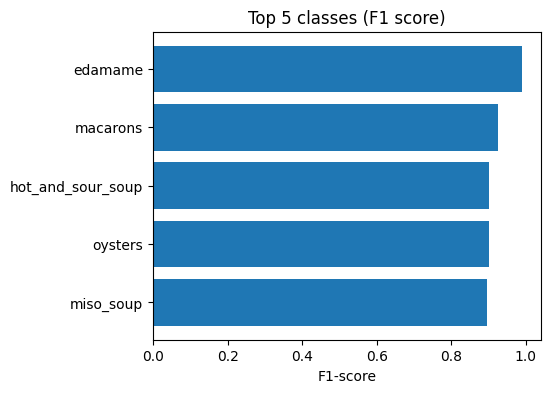

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
scores = ax.barh(range(5), f1score_df["Values"][:5].values)
ax.set_yticks(range(5))
ax.set_yticklabels(f1score_df["Key"][:5])
ax.set_xlabel("F1-score")
ax.set_title("Top 5 classes (F1 score)")
ax.invert_yaxis();

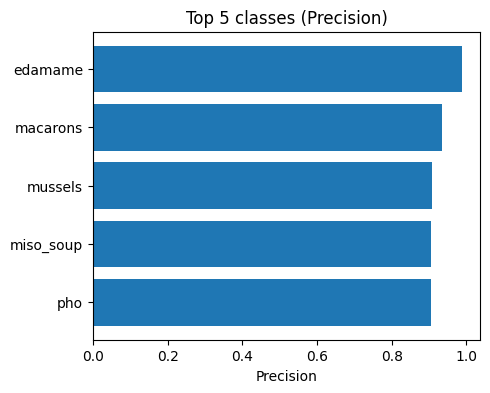

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
scores = ax.barh(range(5), precisions_df["Values"][:5].values)
ax.set_yticks(range(5))
ax.set_yticklabels(precisions_df["Key"][:5])
ax.set_xlabel("Precision")
ax.set_title("Top 5 classes (Precision)")
ax.invert_yaxis();

In [ ]:
import os

custom_food_images = ["/content/drive/MyDrive/food_images/" + img_path for img_path in os.listdir("/content/drive/MyDrive/food_images/")]
custom_food_images

['/content/drive/MyDrive/food_images/samosa.jpeg',
 '/content/drive/MyDrive/food_images/download.jpeg']

In [ ]:
def img_top5_plot(folder_path):
  custom_food_images = [folder_path + img_path for img_path in os.listdir(folder_path)]
  i=0
  fig,a = plt.subplots(len(custom_food_images),2, figsize=(15, 5*len(custom_food_images)-3))

  for img in custom_food_images:
    img = preprocess(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    top_5_i = (pred_prob.argsort())[0][-5:][::-1]
    values = pred_prob[0][top_5_i]
    labels = []
    for x in range(5):
      labels.append(class_names[top_5_i[x]])

    # Plotting Image
    a[i][0].imshow(img/255.)
    a[i][0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
    a[i][0].axis(False)

    # Plotting Models Top 5 Predictions
    a[i][1].bar(labels, values, color='blue');
    a[i][1].set_title('Top 5 Predictions')
    i=i+1

1/1 [==============================] - 0s 45ms/step


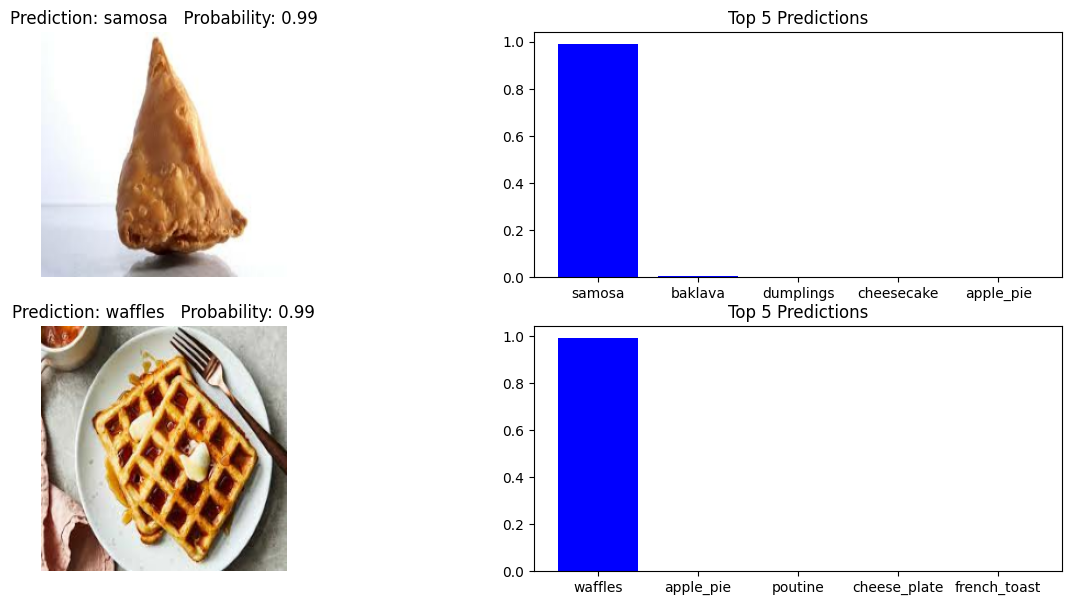

In [ ]:
img_top5_plot("/content/drive/MyDrive/food_images/")

In [ ]:
img = '/content/drive/MyDrive/food_images/samosa.jpeg'

img = preprocess(img, scale=False)
pred_prob = model.predict(tf.expand_dims(img, axis=0))
pred_class = class_names[pred_prob.argmax()]

1/1 [==============================] - 0s 28ms/step


In [ ]:
print(f"Prediction: {pred_class}, Confidence: {pred_prob.max():.2f}")

Prediction: samosa, Confidence: 0.99


In [ ]:
import google.generativeai as genai
genai.configure(api_key='your_key_here')
model_gen = genai.GenerativeModel('gemini-pro')

In [ ]:
specification = input("Would you like any specification for your recipe? ")

Would you like any specification for your recipe? air fried


In [ ]:
content = "Give me a recipe for " + specification + " " + pred_class
response = model_gen.generate_content(content)

print(response.text)

**Ingredients:**

**For the Dough:**
- 1 cup all-purpose flour, plus more for dusting
- 1/4 teaspoon salt
- 1 tablespoon vegetable oil, plus more for greasing
- 1/4 cup water

**For the Filling:**
- 1 pound potatoes, peeled and diced
- 1/2 pound peas, fresh or frozen
- 1 onion, chopped
- 1 serrano pepper, minced (optional)
- 1 teaspoon ground cumin
- 1 teaspoon ground coriander
- 1/2 teaspoon turmeric powder
- 1/4 teaspoon red chili powder
- 1/2 teaspoon salt
- 1/4 cup chopped cilantro

**Instructions:**

**To Make the Dough:**
1. In a large bowl, combine the flour and salt.
2. Add the vegetable oil and water and mix until a dough forms.
3. Knead the dough for 5-7 minutes until it becomes smooth and elastic.
4. Cover the dough and let it rest for at least 30 minutes.

**To Make the Filling:**
1. In a large skillet, heat some vegetable oil over medium heat.
2. Add the potatoes and peas and cook until the potatoes are tender and slightly browned.
3. Add the onion, serrano pepper (if usin